<a href="https://colab.research.google.com/github/Utterbackian/Neuromatch2023_Medical_Imaging/blob/main/EEG_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Utterbackian/Neuromatch2023_Medical_Imaging/blob/main/Loading%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries:

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading:

In [3]:
# Specify the path to your .pth file
file_path = '/content/drive/MyDrive/data/eeg_5_95_std.pth'
loaded_object = torch.load(file_path)

## Index ----> Image ID:

In [4]:
def indexing(field):
    idx_dict = {}
    for i, image in enumerate(loaded_object[field]):
        idx_dict[i] = image
    return idx_dict

def replace_index(loaded_object):
    for EEG in loaded_object['dataset']:
        indexed_labels = indexing("labels")
        indexed_images = indexing("images")
        EEG['image'] = indexed_images[EEG['image']]
        EEG['label'] = indexed_labels[EEG['label']]

In [5]:
replace_index(loaded_object)

## Plots:

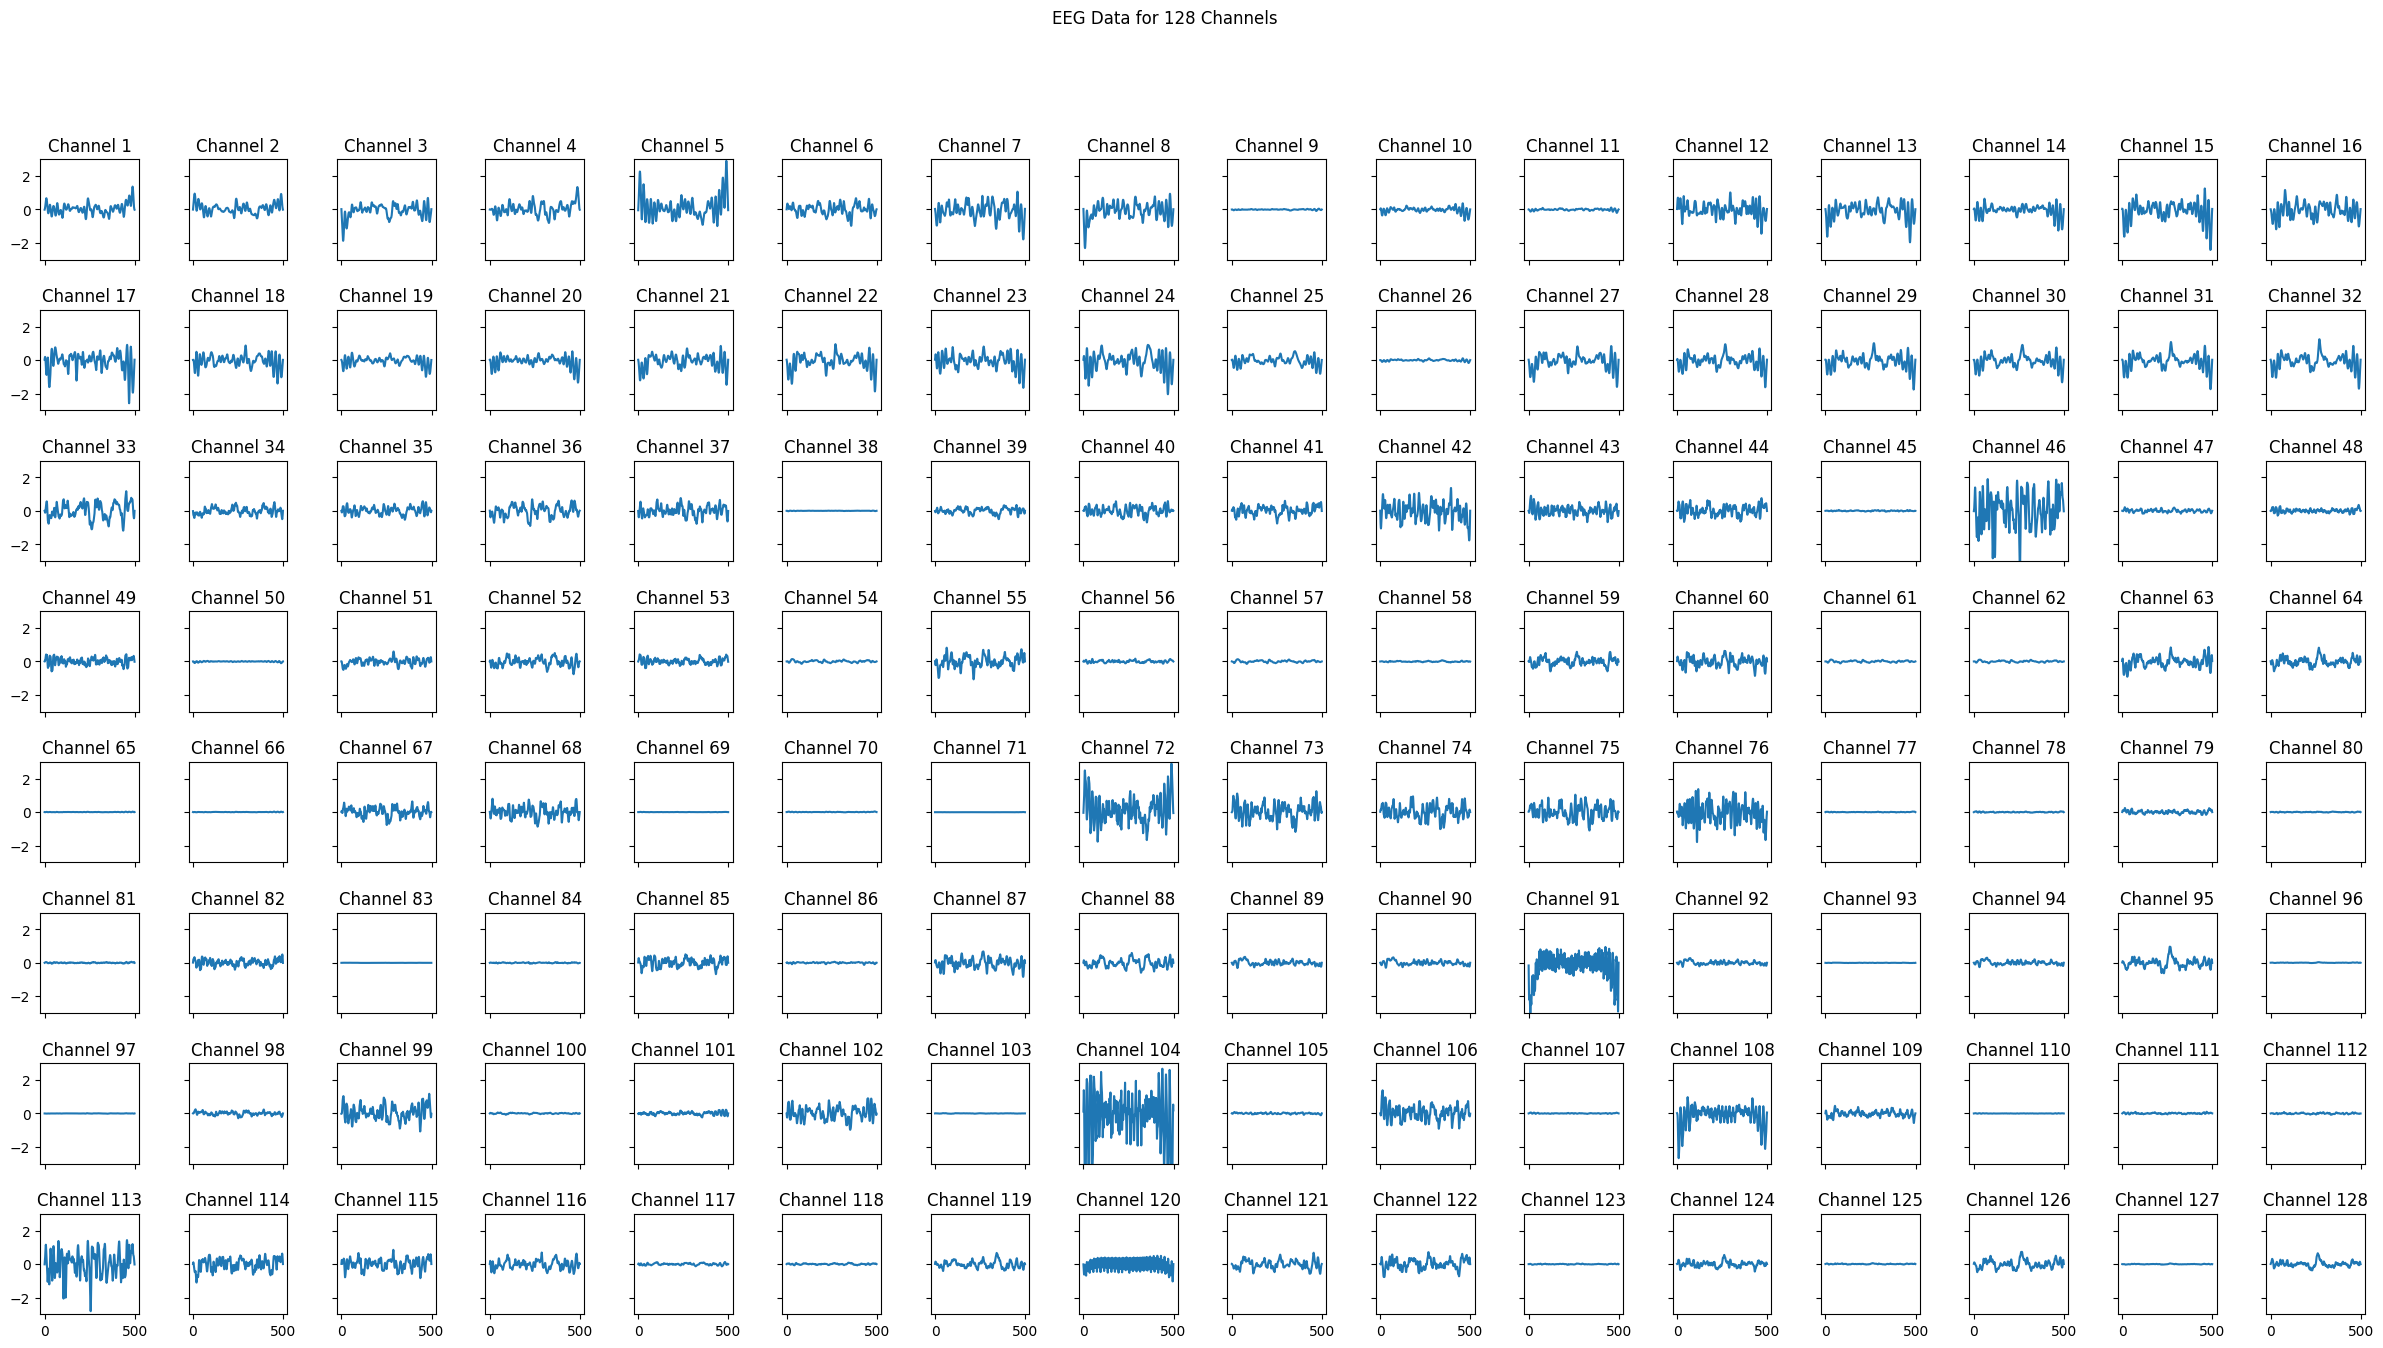

In [6]:
fig, axs = plt.subplots(nrows=8, ncols=16, figsize=(30,15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

axs = axs.flatten()

for i in range(loaded_object['dataset'][0]['eeg'].shape[0]):
    axs[i].plot(loaded_object['dataset'][0]['eeg'][i])
    axs[i].set_title(f"Channel {i+1}")
    axs[i].set_ylim([-3, 3])

for i in range(loaded_object['dataset'][0]['eeg'].shape[0], len(axs)):
    axs[i].axis('off')

fig.suptitle("EEG Data for 128 Channels")

plt.show()

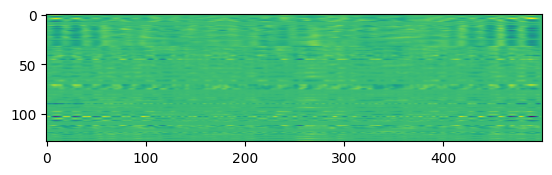

In [7]:
plt.imshow(loaded_object["dataset"][0]['eeg'].numpy())

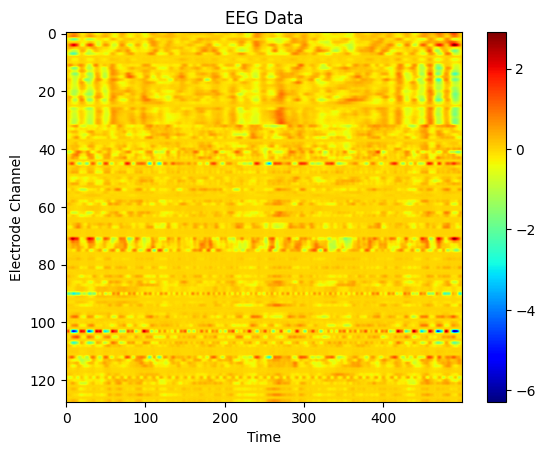

In [8]:
eeg_data = loaded_object['dataset'][0]['eeg']
plt.imshow(eeg_data, aspect='auto', cmap='jet')
plt.colorbar()  # Optional: Include a colorbar for reference
plt.xlabel('Time')
plt.ylabel('Electrode Channel')
plt.title('EEG Data')
plt.show()

In [9]:
eeg = loaded_object['dataset'][0]['eeg'][0]

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


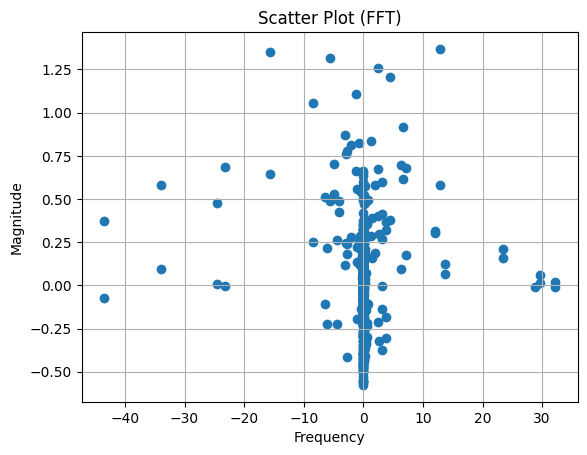

In [10]:
# Plotting frequency vs magnitude
freq = np.fft.fft(eeg)

plt.scatter(freq, eeg)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Scatter Plot (FFT)')
plt.grid()
plt.show()

Text(0, 0.5, 'PowerSD')

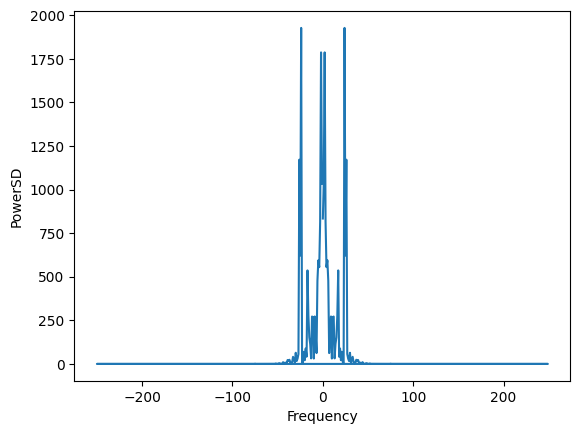

In [11]:
# Plotting power spectrum density
ps = np.abs(np.fft.fft(eeg))**2

time_step = 1 / eeg.shape[0]
freqs = np.fft.fftfreq(eeg.shape[0], time_step)
idx = np.argsort(freqs)

plt.plot(freqs, ps)
plt.xlabel('Frequency')
plt.ylabel('PowerSD')

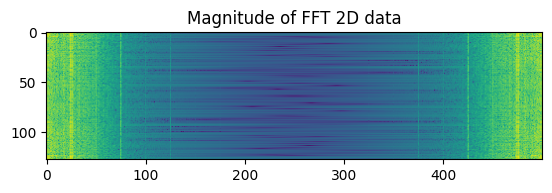

In [12]:
# Plotting magnitude of fft 2d data

plt.title('Magnitude of FFT 2D data')
plt.imshow(np.log(abs(np.fft.fft2(loaded_object["dataset"][0]['eeg'].numpy()))))

## LSTM Encoder

In [13]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(LSTMEncoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size * 2 if bidirectional else hidden_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 128)  # Output 128 units for 1D output

    def forward(self, x):
        # x: Input sequence of shape (batch_size, seq_length, input_size)
        # Output shape: (batch_size, 128)

        # Pass the input sequence through the first LSTM layer
        lstm1_output, _ = self.lstm1(x)

        # Pass the output of the first LSTM layer through the second LSTM layer
        lstm2_output, _ = self.lstm2(lstm1_output)

        # Apply global average pooling along the sequence dimension
        x = torch.mean(lstm2_output, dim=1)

        # Pass through the fully connected layer for 1D output
        output = self.fc(x)

        return output

In [14]:
input_size = 500
hidden_size = 128  # Dimension of the hidden states in the LSTM
num_layers = 2  # Number of LSTM layers
bidirectional = True  # Whether to use bidirectional LSTMs or not
batch_size = 1
eeg_data = loaded_object['dataset'][0]['eeg']

In [15]:
# Initialize the LSTM encoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers, bidirectional)

input_sequence = eeg_data.view(batch_size, 128, 500)

# Pass the input sequence through the encoder
lstm_output = encoder(input_sequence)

# Print the shape of the output
print(lstm_output.shape)  # Shape will be (batch_size, 128) for 1D output

torch.Size([1, 128])


In [16]:
print(lstm_output)

tensor([[ 0.0389, -0.0216, -0.0423,  0.0273, -0.0023, -0.0293,  0.0294,  0.0405,
         -0.0518,  0.0898,  0.0881, -0.0669,  0.0413,  0.0694,  0.0264, -0.0012,
          0.0400, -0.0296,  0.0077, -0.0191,  0.0035,  0.0342, -0.0004,  0.0290,
         -0.0679,  0.0555, -0.0283, -0.0047, -0.0103, -0.0282,  0.0023, -0.0588,
          0.0254,  0.0018, -0.0493, -0.0667,  0.0667,  0.0077, -0.0220,  0.0365,
          0.0657,  0.0273,  0.0528, -0.0310, -0.0559, -0.0323, -0.0459, -0.0004,
          0.0379,  0.0117,  0.0189, -0.0484,  0.0423, -0.0973,  0.0751, -0.0801,
          0.0685, -0.0220, -0.0147, -0.0463, -0.0494, -0.0198,  0.0833, -0.0310,
         -0.0450,  0.0045,  0.0804, -0.0695,  0.0154,  0.0096, -0.0522,  0.0564,
          0.0723, -0.0168, -0.0248, -0.0357, -0.0022,  0.0380,  0.0711,  0.0889,
         -0.0120, -0.0371,  0.0102,  0.0558,  0.0047,  0.0146,  0.0683,  0.0355,
         -0.0497, -0.0356, -0.0369, -0.0034,  0.0642, -0.0514,  0.0552,  0.0335,
         -0.0622,  0.0031,  

## Transformer Encoder

In [17]:
class TransformerEEG(nn.Module):
    def __init__(self, input_size, d_model, nhead, dim_feedforward, num_encoder_layers, output_size):
        super(TransformerEEG, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change to (seq_length, batch_size, d_model)
        x = self.encoder(x)
        x = torch.mean(x, dim=0)  # Global average pooling
        x = self.fc(x)
        return x

In [18]:
d_model = 128  # Model's hidden dimension (Embedding size)
nhead = 8  # Number of attention heads
dim_feedforward = 256  # Dimension of the feedforward layers
num_encoder_layers = 6  # Number of encoder layers in the Transformer
output_size = 128  # Size of the 1D output

# Initialize the Transformer EEG model
transformer_eeg = TransformerEEG(input_size, d_model, nhead, dim_feedforward, num_encoder_layers, output_size)

input_sequence = eeg_data.view(batch_size, 128, 500)

# Pass the input sequence through the model
transf_output = transformer_eeg(input_sequence)

# Print the shape of the output
print(transf_output.shape)

torch.Size([1, 128])


In [ ]:
print(transf_output)

## Adding Noise, conditioning vector

In [20]:
def addNoise(output, sigma):

    # Generate Gaussian noise with the same shape as the encoded vector
    noise = torch.randn_like(output) * sigma

    # Add the noise to the encoded vector
    return torch.cat((output, noise))

In [ ]:
from matplotlib.text import Real
sigma = 0.1

EEG_feature_noise = addNoise(lstm_output, sigma) # adding noise to lstm output
#GAN_EEG_input = addNoise(transf_output, sigma) # adding noise to transformer output
print(lstm_output)
print(EEG_feature_noise)

##Load Images

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

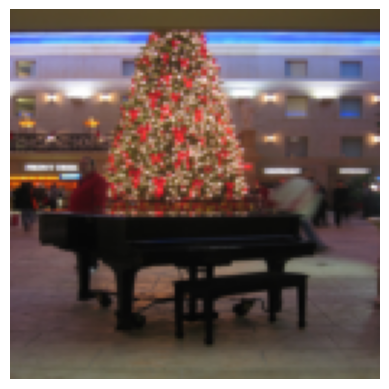

In [33]:
def getImage(image_id):
  image_path = '/content/drive/MyDrive/filtered/' + image_id + '.JPEG'

  r = transforms.Compose([transforms.Resize((128,128))])
  return (np.array(r(Image.open(image_path))))

img = getImage("n03452741_5499")
plt.imshow(img)
plt.axis('off')
plt.show()

##GAN Model from EEG2Image Paper converted to Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torchvision.transforms.functional as TF

In [ ]:
#EEG_feature_noise = con(eeg, noise)          2 x 128
Real_images = img                             # 128 x 128 x 3
#Fake_images = Fake_Generator(EEG_feature_noise)    #2 x 128 -> 128 x 128 x 3

#X =

#C =

class Generator(nn.Module):
    def __init__(self, n_class=10, res=128):
        super(Generator, self).__init__()
        filters = [1024, 512, 256, 128, 64, 32]  # , 16]
        strides = [4, 2, 2, 2, 2, 2]  # , 2]

        self.cnn_depth = len(filters)

        # For discrete condition we are using Embedding
        self.cond_embedding = nn.Embedding(num_embeddings=n_class, embedding_dim=50)
        self.cond_flat = nn.Flatten()
        self.cond_dense = nn.Linear(in_features=8 * 8 * 1, out_features=64)
        self.cond_reshape = nn.Reshape((64,))

        # Hyperparameter:
        # If only conv  : mean=0.0, var=0.02
        # If using bnorm: mean=1.0, var=0.02
        self.conv = nn.ModuleList([
            spectral_norm(nn.ConvTranspose2d(
                in_channels=1, out_channels=filters[idx], kernel_size=3,
                stride=strides[idx], padding=1, bias=False))
            for idx in range(self.cnn_depth)
        ])

        self.act = nn.ModuleList([nn.LeakyReLU() for idx in range(self.cnn_depth)])
        self.bnorm = nn.ModuleList([nn.BatchNorm2d(filters[idx]) for idx in range(self.cnn_depth)])

        self.last_conv = spectral_norm(nn.Conv2d(
            in_channels=filters[-1], out_channels=3, kernel_size=3,
            stride=1, padding=1, bias=False))

    def forward(self, X):
        X = X.unsqueeze(2).unsqueeze(3)
        X = self.act[0](self.conv[0](X))

        for idx in range(1, self.cnn_depth):
            X = self.act[idx](self.bnorm[idx](self.conv[idx](X)))
        X = self.last_conv(X)
        return X

class Discriminator(nn.Module):
    def __init__(self, n_class=10, res=128):
        super(Discriminator, self).__init__()
        filters = [64, 128, 256, 512, 1024, 1]
        strides = [2, 2, 2, 2, 1, 1]
        self.cnn_depth = len(filters)

        self.cond_embedding = nn.Embedding(num_embeddings=n_class, embedding_dim=50)
        self.cond_flat = nn.Flatten()
        self.cond_dense = nn.Linear(in_features=res * res * 1, out_features=res * res * 1)
        self.cond_reshape = nn.Reshape((res, res, 1))

        self.cnn_conv = nn.ModuleList([
            spectral_norm(nn.Conv2d(
                in_channels=1, out_channels=filters[i], kernel_size=3,
                stride=strides[i], padding=1, bias=False))
            for i in range(self.cnn_depth)
        ])

        self.cnn_bnorm = nn.ModuleList([nn.BatchNorm2d(filters[i]) for i in range(self.cnn_depth)])
        self.cnn_act = nn.ModuleList([nn.LeakyReLU(negative_slope=0.2) for i in range(self.cnn_depth)])

        self.flat = nn.Flatten()
        self.disc_out = nn.Linear(in_features=res * res * 1, out_features=1)

    def forward(self, x, C):
        C = C.unsqueeze(2).unsqueeze(3)
        C = C.expand(-1, x.shape[1], x.shape[2], -1)
        x = torch.cat([x, C], dim=-1)

        for layer_no in range(self.cnn_depth):
            x = self.cnn_act[layer_no](self.cnn_bnorm[layer_no](self.cnn_conv[layer_no](x)))

        reconst_x = None
        x = self.disc_out(self.flat(x))

        return x, reconst_x

class DCGAN(nn.Module):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.gen = Generator()
        self.disc = Discriminator()

    def forward(self, X, C):
        """
        X:  Real or fake images (Discriminator inputs)
        C:  Conditional vector (EEG Features 1D vector concat with noise)
        """
        return self.gen(X), self.disc(X, C)

In [ ]:
def dist_train_step(mirrored_strategy, model, model_gopt, model_copt, X, C, latent_dim=96, batch_size=64):
    diff_augment_policies = "color,translation"
    noise_vector = torch.rand(batch_size, latent_dim, device=X.device) * 2 - 1
    noise_vector_2 = torch.rand(batch_size, latent_dim, device=X.device) * 2 - 1
    noise_vector = torch.cat([noise_vector, C], dim=-1)
    noise_vector_2 = torch.cat([noise_vector_2, C], dim=-1)

    def disc_hinge(D_real, D_fake):
        return (torch.mean(nn.ReLU()(1 - D_real)) + torch.mean(nn.ReLU()(1 + D_fake))) / 2

    def gen_hinge(D_fake):
        return -torch.mean(D_fake)

    def train_step_disc(model, model_gopt, model_copt, X, C, latent_dim=96, batch_size=64):
        model_copt.zero_grad()

        fake_img = model.gen(noise_vector)

        X_aug = TF.affine(TF.to_pil_image(X), *TF._get_inverse_affine_args(*TF._random_affine(TF.to_tensor(X), **TF.random_affine_params(0, 0.3, 0.1, 0.1, 5, False)), TF.to_pil_image(X).size, interpolation=TF.InterpolationMode.BILINEAR))
        X_aug = TF.to_tensor(X_aug).to(X.device)
        fake_img = TF.affine(TF.to_pil_image(fake_img), *TF._get_inverse_affine_args(*TF._random_affine(TF.to_tensor(fake_img), **TF.random_affine_params(0, 0.3, 0.1, 0.1, 5, False)), TF.to_pil_image(fake_img).size, interpolation=TF.InterpolationMode.BILINEAR))
        fake_img = TF.to_tensor(fake_img).to(X.device)

        D_real, X_recon = model.disc(X_aug, C, training=True)
        D_fake, _ = model.disc(fake_img, C, training=True)

        c_loss = disc_hinge(D_real, D_fake)

        c_loss.backward()
        model_copt.step()
        return c_loss.item()

    def train_step_gen(model, model_gopt, model_copt, X, C, latent_dim=96, batch_size=64):
        model_gopt.zero_grad()

        fake_img_o = model.gen(noise_vector)
        fake_img_2_o = model.gen(noise_vector_2)
        fake_img = TF.affine(TF.to_pil_image(fake_img_o), *TF._get_inverse_affine_args(*TF._random_affine(TF.to_tensor(fake_img_o), **TF.random_affine_params(0, 0.3, 0.1, 0.1, 5, False)), TF.to_pil_image(fake_img_o).size, interpolation=TF.InterpolationMode.BILINEAR))
        fake_img = TF.to_tensor(fake_img).to(X.device)
        fake_img_2 = TF.affine(TF.to_pil_image(fake_img_2_o), *TF._get_inverse_affine_args(*TF._random_affine(TF.to_tensor(fake_img_2_o), **TF.random_affine_params(0, 0.3, 0.1, 0.1, 5, False)), TF.to_pil_image(fake_img_2_o).size, interpolation=TF.InterpolationMode.BILINEAR))
        fake_img_2 = TF.to_tensor(fake_img_2).to(X.device)

        D_fake, _ = model.disc(fake_img, C, training=False)
        D_fake_2, _ = model.disc(fake_img_2, C, training=False)
        g_loss = gen_hinge(D_fake) + gen_hinge(D_fake_2)
        mode_loss = torch.mean(torch.abs(fake_img_2_o - fake_img_o)) / torch.mean(torch.abs(noise_vector_2 - noise_vector))
        mode_loss = 1.0 / (mode_loss + 1e-5)
        g_loss = g_loss + 1.0 * mode_loss

        g_loss.backward()
        model_gopt.step()
        return g_loss.item()

    model.train()
    model_gopt = optim.Adam(model.gen.parameters())
    model_copt = optim.Adam(model.disc.parameters())
    per_replica_loss_disc = mirrored_strategy.run(train_step_disc, args=(model, model_gopt, model_copt, X, C, latent_dim, batch_size,))
    per_replica_loss_gen = mirrored_strategy.run(train_step

##GAN and Training Loop(OLD!)

To summarize, during training, the generator takes random noise as input and generates images. The discriminator takes both real EEG data and the generated images as input and tries to distinguish between the real and generated data. The GAN's objective is to improve the generator's ability to produce realistic images that can "fool" the discriminator, leading to a more accurate representation of the real visual stimuli from the EEG data.

In [ ]:
Noise
128

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

can you modify the code, if you need to, to get an eeg input vector of size 1 x 128

ChatGPT:
Sure, I can modify the code to accommodate an EEG input vector of size 1x128. We'll need to update the generator and discriminator architectures accordingly to handle this input size. Here's the modified code:

In [ ]:
#Generator and Discriminator networks:
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_size),
            nn.Tanh()  # To normalize the output between -1 and 1 (assuming image data is normalized in that range)
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # To produce a probability score (0 to 1) for discriminator's output
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#Preprocess EEG and Image data:
class EEGDataset(Dataset):
    def __init__(self, eeg_data, image_data, transform=None):
        self.eeg_data = eeg_data
        self.image_data = image_data
        self.transform = transform

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, index):
        eeg_sample = self.eeg_data[index]
        image_sample = self.image_data[index]

        if self.transform:
            eeg_sample = self.transform(eeg_sample)
            image_sample = self.transform(image_sample)

        return eeg_sample, image_sample

#EEG data and Image data (convert to PyTorch tensors, normalize, etc.)
eeg_data = GAN_EEG_input
image_data = ...

# Create instances of EEGDataset for training and testing
train_dataset = EEGDataset(eeg_data=train_eeg_data, image_data=train_image_data, transform=transform)
test_dataset = EEGDataset(eeg_data=test_eeg_data, image_data=test_image_data, transform=transform)

# Create DataLoader for batch processing
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Initialize the Generator, Discriminator, and other necessary components:
input_size = 128  # Size of the input EEG data
output_size = 64  # Size of the generated image data
generator = Generator(input_size, output_size)
discriminator = Discriminator(input_size)

# Define loss function and optimizers
criterion = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Update the generator and discriminator input size
input_size = 128
output_size = 64

# Generator and Discriminator instances
generator = Generator(input_size, output_size)
discriminator = Discriminator(input_size)

# Generator and Discriminator optimizers (unchanged)
criterion = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# EEG data should be of shape (batch_size, 1, 128)
# Here, the batch size will be determined by the DataLoader
for batch_idx, (eeg_samples, real_images) in enumerate(dataloader):
    # Reshape the EEG data to (batch_size, 128) if needed
    eeg_samples = eeg_samples.view(-1, 128)

In [ ]:
#Training loop:
def train_gan(generator, discriminator, dataloader, num_epochs=50):
    for epoch in range(num_epochs):
        for batch_idx, (eeg_samples, real_images) in enumerate(dataloader):
            # Training the Discriminator
            discriminator.zero_grad()
            real_labels = torch.ones(eeg_samples.size(0), 1)
            fake_labels = torch.zeros(eeg_samples.size(0), 1)

            # Forward pass with real data
            real_outputs = discriminator(eeg_samples)
            real_loss = criterion(real_outputs, real_labels)

            # Forward pass with generated data
            noise = torch.randn(eeg_samples.size(0), input_size)
            generated_images = generator(noise)
            fake_outputs = discriminator(generated_images)
            fake_loss = criterion(fake_outputs, fake_labels)

            # Total Discriminator loss
            discriminator_loss = real_loss + fake_loss
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # Training the Generator
            generator.zero_grad()
            noise = torch.randn(eeg_samples.size(0), input_size)
            generated_images = generator(noise)
            outputs = discriminator(generated_images)
            generator_loss = criterion(outputs, real_labels)
            generator_loss.backward()
            generator_optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} "
                      f"Discriminator Loss: {discriminator_loss.item():.4f}, "
                      f"Generator Loss: {generator_loss.item():.4f}")

train_gan(generator, discriminator, train_dataloader, num_epochs=50)